# CIPLA Stock Market Analysis using PySpark (RDD + DataFrame + SQL)

This Colab notebook analyzes the CIPLA stock dataset using PySpark. It includes RDD examples, DataFrame operations, Spark SQL, feature engineering (daily returns, moving averages), volatility analysis, and visualizations.

Run cells step-by-step. When asked to upload the CSV, upload your `CIPLA.csv` file.

In [1]:
# Step 1: Install PySpark
!pip install -q pyspark
print(' PySpark installed')

✅ PySpark installed


In [3]:
import os #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" #set environment variable
  !java -version #check java version
install_java()

openjdk version "1.8.0_462"
OpenJDK Runtime Environment (build 1.8.0_462-8u462-ga~us1-0ubuntu2~22.04.2-b08)
OpenJDK 64-Bit Server VM (build 25.462-b08, mixed mode)


In [52]:
# Step 2: Initialize SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('CIPLA_Stock_Analysis').getOrCreate()
sc = spark.sparkContext


In [53]:
# Step 3: Upload CIPLA.csv file
df_cipla = spark.read.format("csv").option("header","True").option("inferSchema",True).load("/content/CIPLA .csv")

In [68]:


# Step 4 (REVISED): Load with spark.read.format() and name as df_cipla
from pyspark.sql.functions import col, to_date, to_timestamp
from pyspark.sql.types import DoubleType

print("--- Starting Revised Step 4 ---")

# 1. Load using your requested format.
# We use the 'csv_file' variable from Step 3
# We set inferSchema=False because it will fail on this file's bad rows.
print(f"Loading '{csv_file}' using spark.read.format()...")
df_raw = spark.read.format("csv").option("header", "True").option("inferSchema", "False").load(csv_file)

print("Raw schema (all strings):")
df_raw.printSchema()

# 2. Filter out the bad "Ticker" and "Date" rows
df_filtered = df_raw.filter(
    (col('Price') != 'Ticker') & (col('Price') != 'Date')
)

# 3. Now, let's fix the columns
#    Convert 'Price' column to 'Date'
#    Cast all numeric columns to DoubleType
numeric_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Start with the filtered data
df_temp = df_filtered.withColumn('Date', to_date(to_timestamp(col('Price'))))

for col_name in numeric_cols:
    if col_name in df_temp.columns:
        df_temp = df_temp.withColumn(col_name, col(col_name).cast(DoubleType()))

# 4. Select final columns and assign to your 'df_cipla' variable
final_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df_cipla = df_temp.select([c for c in final_cols if c in df_temp.columns])


print("\nCleaned Schema (DataFrame: df_cipla):")
df_cipla.printSchema()

print("\nCleaned Sample Rows (DataFrame: df_cipla):")
df_cipla.show(5, truncate=False)

--- Starting Revised Step 4 ---
Loading 'CIPLA  (1).csv' using spark.read.format()...
Raw schema (all strings):
root
 |-- Price: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- Volume: string (nullable = true)


Cleaned Schema (DataFrame: df_cipla):
root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: double (nullable = true)


Cleaned Sample Rows (DataFrame: df_cipla):
+----------+-----------+-----------+-----------+-----------+-----------+---------+
|Date      |Open       |High       |Low        |Close      |Adj Close  |Volume   |
+----------+-----------+-----------+-----------+-----------+-----------+---------+
|1996-01-01|8.778665543|8.8

In [63]:
# Step 5: Data cleaning and basic exploration
from pyspark.sql.functions import isnan, when, count, sum as _sum, col
df=df_cipla
# Drop duplicate rows
before = df.count()
df = df.dropDuplicates()
after = df.count()
print(f'Rows before: {before}, after dropDuplicates: {after}, removed: {before-after}')


# Null counts per column
# We apply isnan() ONLY to numeric columns to avoid the error
numeric_types = ['float', 'double']
null_check_expressions = []

for col_name, col_type in df.dtypes:
    if col_type in numeric_types:
        # For numeric types, check both isNull and isNaN
        expr = _sum(when(col(col_name).isNull() | isnan(col(col_name)), 1).otherwise(0)).alias(col_name)
    else:
        # For non-numeric types (like Date), ONLY check isNull
        expr = _sum(when(col(col_name).isNull(), 1).otherwise(0)).alias(col_name)
    null_check_expressions.append(expr)

null_counts = df.select(null_check_expressions)

print('Null counts per column:')
null_counts.show(truncate=False)

# Show describe for numeric columns
print('Summary statistics:')
df.describe().show()

# Re-assign df_cipla to the cleaned version
df_cipla = df

Rows before: 7252, after dropDuplicates: 7252, removed: 0
Null counts per column:
+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|0   |0   |0   |0  |0    |0        |0     |
+----+----+----+---+-----+---------+------+

Summary statistics:
+-------+------------------+-----------------+-----------------+------------------+-----------------+------------------+
|summary|              Open|             High|              Low|             Close|        Adj Close|            Volume|
+-------+------------------+-----------------+-----------------+------------------+-----------------+------------------+
|  count|              7252|             7252|             7252|              7252|             7252|              7252|
|   mean|384.15312774473205|388.8218055427242|378.7351945864933|383.53602331636307|364.3548492923425|1661769.8798952014|
| stddev|358.04488667120023|361.5459633605955|353.9001035885163| 357.570

In [64]:
# Step 6: RDD examples (map, filter, reduce)
# Convert DataFrame to RDD of Rows
rdd = df_cipla.rdd

# Example: extract Close column safely
def safe_get_close(row):
    try:
        return float(row['Close'])
    except Exception:
        return None

close_rdd = rdd.map(lambda r: safe_get_close(r)).filter(lambda x: x is not None)

print('Sample close values (first 10):', close_rdd.take(10))

# Min, max, avg using RDD actions
min_close = close_rdd.min()
max_close = close_rdd.max()
total = close_rdd.reduce(lambda a,b: a+b)
count = close_rdd.count()
avg_close = total / count if count>0 else None

print(f'Min Close: {min_close}, Max Close: {max_close}, Avg Close: {avg_close}')

# Create a safe function to compare Open and Close
def safe_compare_close_open(row):
    try:
        # Try to convert both to float
        close_val = float(row['Close'])
        open_val = float(row['Open'])
        # Perform the comparison
        return close_val > open_val
    except (ValueError, TypeError, AttributeError):
        # If conversion fails or data is None (e.g., 'CIPLA.NS' or None)
        return False

# Use this safe function in your filter
high_close_days = rdd.filter(safe_compare_close_open)

print('Days Close > Open (count):', high_close_days.count())

Sample close values (first 10): [21.21866608, 19.99733353, 26.13199997, 56.09999847, 108.0719986, 91.61199951, 97.76000214, 99.86000061, 110.6800003, 118.1800003]
Min Close: 4.716800213, Max Close: 1680.5, Avg Close: 383.53602331636307
Days Close > Open (count): 3181


In [65]:
# Step 7: Feature engineering - Prev_Close, Daily_Return, SMA_50, SMA_200, Volatility_30
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, avg, stddev, col

# Order by Date for window operations
# This works now because 'Date' column exists from our new Step 4
w = Window.orderBy('Date')
df_cipla_fe = df_cipla.withColumn('Prev_Close', lag('Close').over(w))
df_cipla_fe = df_cipla_fe.withColumn('Daily_Return', ((col('Close') - col('Prev_Close'))/col('Prev_Close'))*100)

# SMA windows
w50 = Window.orderBy('Date').rowsBetween(-49,0)
w200 = Window.orderBy('Date').rowsBetween(-199,0)
df_cipla_fe = df_cipla_fe.withColumn('SMA_50', avg('Close').over(w50)).withColumn('SMA_200', avg('Close').over(w200))

# Volatility: 30-day stddev of returns
w30 = Window.orderBy('Date').rowsBetween(-29,0)
df_cipla_fe = df_cipla_fe.withColumn('Volatility_30', stddev('Daily_Return').over(w30))

print('Feature engineered schema:')
df_cipla_fe.printSchema()
df_cipla_fe.select('Date','Close','Prev_Close','Daily_Return','SMA_50','SMA_200','Volatility_30').show(10, truncate=False)

Feature engineered schema:
root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Prev_Close: double (nullable = true)
 |-- Daily_Return: double (nullable = true)
 |-- SMA_50: double (nullable = true)
 |-- SMA_200: double (nullable = true)
 |-- Volatility_30: double (nullable = true)

+----------+-----------+-----------+--------------------+-----------------+-----------------+-------------------+
|Date      |Close      |Prev_Close |Daily_Return        |SMA_50           |SMA_200          |Volatility_30      |
+----------+-----------+-----------+--------------------+-----------------+-----------------+-------------------+
|1996-01-01|8.831999779|NULL       |NULL                |8.831999779      |8.831999779      |NULL               |
|1996-01-02|8.720000267|8.831999779|-1.2681104

In [66]:
# Step 8: SQL queries & EDA
# Register view

df_cipla_fe.createOrReplaceTempView('cipla_clean')

# Null counts via SQL
print('Null counts (SQL):')
spark.sql("""
SELECT
SUM(CASE WHEN Date IS NULL THEN 1 ELSE 0 END) AS Date_NullCount,
SUM(CASE WHEN Open IS NULL THEN 1 ELSE 0 END) AS Open_NullCount,
SUM(CASE WHEN High IS NULL THEN 1 ELSE 0 END) AS High_NullCount,
SUM(CASE WHEN Low IS NULL THEN 1 ELSE 0 END) AS Low_NullCount,
SUM(CASE WHEN Close IS NULL THEN 1 ELSE 0 END) AS Close_NullCount,
SUM(CASE WHEN Volume IS NULL THEN 1 ELSE 0 END) AS Volume_NullCount
FROM cipla_clean
""").show()

# Summary stats for Close
spark.sql("""
SELECT MIN(Close) AS Min_Close, MAX(Close) AS Max_Close, ROUND(AVG(Close),2) AS Avg_Close, ROUND(STDDEV(Close),4) AS StdDev_Close
FROM cipla_clean
""").show()

# Top volatile days
spark.sql("""
SELECT Date, Close, Daily_Return FROM cipla_clean ORDER BY ABS(Daily_Return) DESC LIMIT 10
""").show()

# Monthly average close and volume
spark.sql("""
SELECT MONTH(Date) AS Month, ROUND(AVG(Close),2) AS Avg_Close, ROUND(AVG(Volume),0) AS Avg_Volume
FROM cipla_clean
GROUP BY MONTH(Date)
ORDER BY Month
""").show()

Null counts (SQL):
+--------------+--------------+--------------+-------------+---------------+----------------+
|Date_NullCount|Open_NullCount|High_NullCount|Low_NullCount|Close_NullCount|Volume_NullCount|
+--------------+--------------+--------------+-------------+---------------+----------------+
|             0|             0|             0|            0|              0|               0|
+--------------+--------------+--------------+-------------+---------------+----------------+

+-----------+---------+---------+------------+
|  Min_Close|Max_Close|Avg_Close|StdDev_Close|
+-----------+---------+---------+------------+
|4.716800213|   1680.5|   383.54|    357.5707|
+-----------+---------+---------+------------+

+----------+-----------+------------------+
|      Date|      Close|      Daily_Return|
+----------+-----------+------------------+
|2003-11-27|95.79599762|1224.1733982267185|
|2004-04-27|107.5279999|1190.7902846443071|
|2003-12-26|103.0439987|1170.2661833488937|
|2003-04-1

--- Generating Null Count Plot ---
Tidy Null Counts to be plotted:
  Column_Name  Null_Count
0        Date           0
1        Open           0
2        High           0
3         Low           0
4       Close           0
5      Volume           0
6   Adj Close           0

Saved plot to null_counts_barchart.png


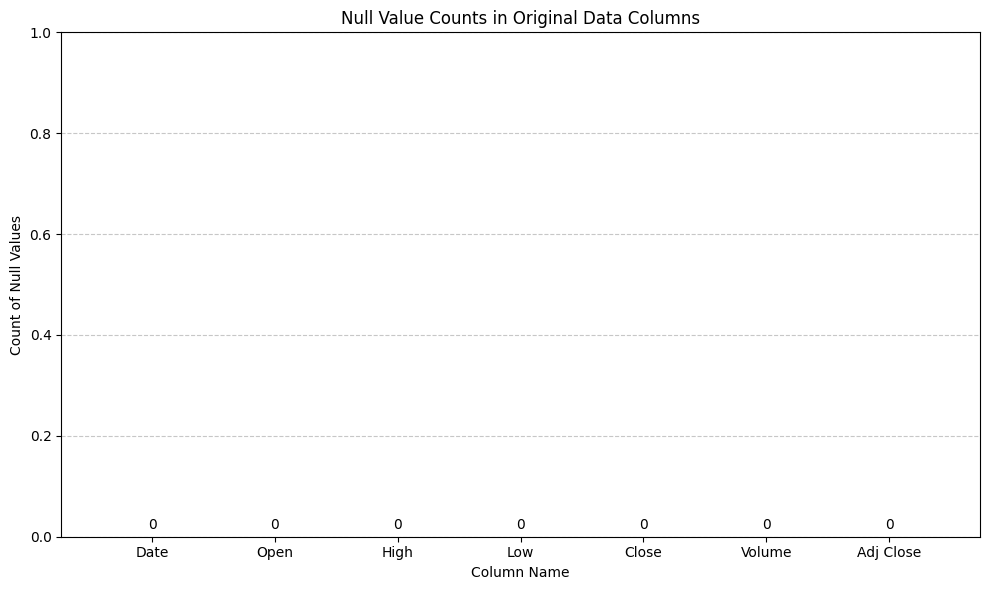

In [67]:
# Step 8a: Visualize Null Counts
import matplotlib.pyplot as plt
import pandas as pd

print("--- Generating Null Count Plot ---")

# 1. Run your SQL query to get the wide-format null counts
null_counts_spark_df_cipla = spark.sql("""
    SELECT
        SUM(CASE WHEN Date IS NULL THEN 1 ELSE 0 END) AS Date,
        SUM(CASE WHEN Open IS NULL THEN 1 ELSE 0 END) AS Open,
        SUM(CASE WHEN High IS NULL THEN 1 ELSE 0 END) AS High,
        SUM(CASE WHEN Low IS NULL THEN 1 ELSE 0 END) AS Low,
        SUM(CASE WHEN Close IS NULL THEN 1 ELSE 0 END) AS Close,
        SUM(CASE WHEN Volume IS NULL THEN 1 ELSE 0 END) AS Volume,
        SUM(CASE WHEN `Adj Close` IS NULL THEN 1 ELSE 0 END) AS `Adj Close`
    FROM cipla_clean
""")

# 2. Convert the small Spark DataFrame (1 row) to Pandas
pdf_cipla_null_counts_wide = null_counts_spark_df_cipla.toPandas()

# 3. "Melt" the DataFrame to make it "tidy" for plotting
#    (From: | Date | Open | ... | to: | Column_Name | Null_Count |)
if not pdf_cipla_null_counts_wide.empty:
    pdf_cipla_null_counts_tidy = pdf_cipla_null_counts_wide.melt(
        var_name='Column_Name',
        value_name='Null_Count'
    )

    print("Tidy Null Counts to be plotted:")
    print(pdf_cipla_null_counts_tidy)

    # 4. Plot with Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(pdf_cipla_null_counts_tidy['Column_Name'], pdf_cipla_null_counts_tidy['Null_Count'])

    plt.title('Null Value Counts in Original Data Columns')
    plt.xlabel('Column Name')
    plt.ylabel('Count of Null Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels on top of each bar (all should be '0')
    for index, value in enumerate(pdf_cipla_null_counts_tidy['Null_Count']):
        plt.text(index, value + 0.01, str(value), ha='center', va='bottom')

    # Ensure y-axis starts at 0
    plt.ylim(bottom=0, top=1) # Set top to 1 so the '0' is clearly visible

    plt.tight_layout()

    # Save the plot (optional) and show it
    plt.savefig('null_counts_barchart.png')
    print("\nSaved plot to null_counts_barchart.png")
    plt.show()

else:
    print("Error: No data returned from null count query.")

In [61]:
# Step 9: Correlation & Moving Average Crossover signals
# Correlations
corr_close_vol = df_cipla_fe.stat.corr('Close','Volume')
print('Correlation Close vs Volume:', corr_close_vol)

# Identify MA crossover signals
from pyspark.sql.functions import when

df_cipla_signal = df_cipla_fe.withColumn('MA_Signal', when(col('SMA_50')>col('SMA_200'), 1).when(col('SMA_50')<col('SMA_200'), -1).otherwise(0))
df_cipla_signal.select('Date','Close','SMA_50','SMA_200','MA_Signal').show(10)


Correlation Close vs Volume: 0.29116465579218487
+----------+-----------+-----------------+-----------------+---------+
|      Date|      Close|           SMA_50|          SMA_200|MA_Signal|
+----------+-----------+-----------------+-----------------+---------+
|1996-01-01|8.831999779|      8.831999779|      8.831999779|        0|
|1996-01-02|8.720000267|      8.776000023|      8.776000023|        0|
|1996-01-03|8.658665657|8.736888567666666|8.736888567666666|        0|
|1996-01-04| 8.56799984|    8.69466638575|    8.69466638575|        0|
|1996-01-05|8.546666145|     8.6650663376|     8.6650663376|        0|
|1996-01-08|8.399999619|8.620888551166667|8.620888551166667|        0|
|1996-01-09|8.422665596|8.592570986142858|8.592570986142858|        0|
|1996-01-10|8.491999626|   8.579999566125|   8.579999566125|        0|
|1996-01-11|8.578665733|8.579851362444444|8.579851362444444|        0|
|1996-01-12|8.727999687|     8.5946661949|     8.5946661949|        0|
+----------+-----------+----

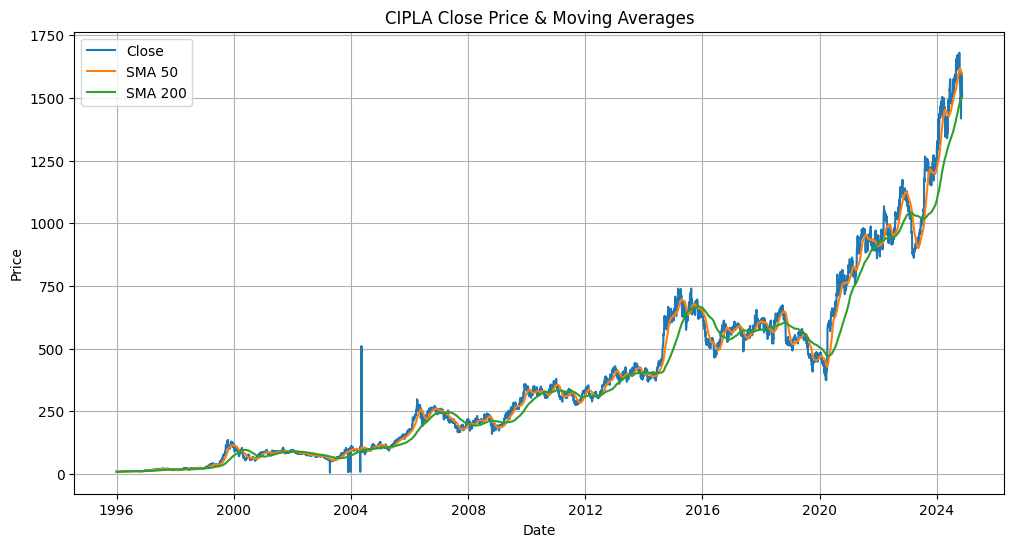

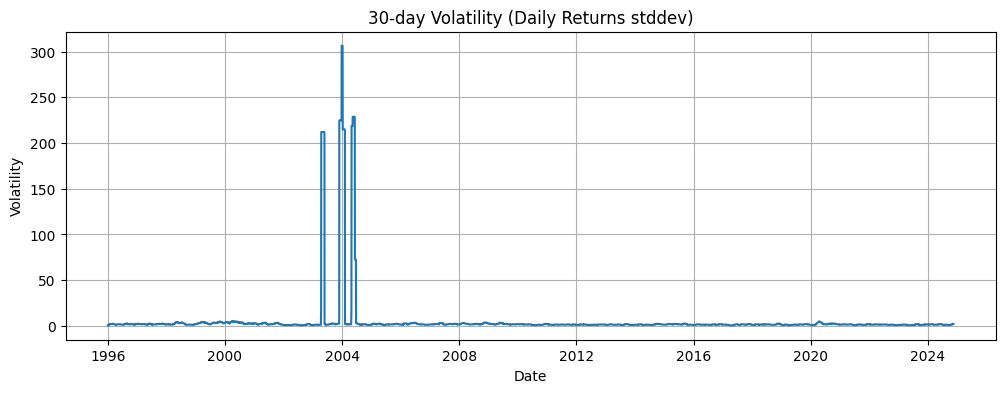

In [28]:
# Step 10: Visualizations - Closing Price, SMA, Volatility
import matplotlib.pyplot as plt

pdf_cipla = df_cipla_signal.select('Date','Close','SMA_50','SMA_200','Volatility_30').orderBy('Date').toPandas()

plt.figure(figsize=(12,6))
plt.plot(pdf_cipla['Date'], pdf_cipla['Close'], label='Close')
plt.plot(pdf_cipla['Date'], pdf_cipla['SMA_50'], label='SMA 50')
plt.plot(pdf_cipla['Date'], pdf_cipla['SMA_200'], label='SMA 200')
plt.legend()
plt.title('CIPLA Close Price & Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(pdf_cipla['Date'], pdf_cipla['Volatility_30'])
plt.title('30-day Volatility (Daily Returns stddev)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

In [29]:
# Step 12: Save cleaned data and sample outputs
out_dir = '/content/cipla_analysis_outputs'
import os
os.makedirs(out_dir, exist_ok=True)

# Save parquet and sample CSV
clean_parquet = out_dir + '/cleaned_parquet'
df_cipla_signal.write.mode('overwrite').parquet(clean_parquet)

sample_csv = out_dir + '/sample_head.csv'
df_cipla_signal.limit(200).toPandas().to_csv(sample_csv, index=False)

print('Saved cleaned parquet to', clean_parquet)
print('Saved sample CSV to', sample_csv)

Saved cleaned parquet to /content/cipla_analysis_outputs/cleaned_parquet
Saved sample CSV to /content/cipla_analysis_outputs/sample_head.csv


## Conclusion & Next steps

- You now have a Colab notebook that reads CIPLA data, performs RDD and DataFrame operations, computes features (returns, moving averages, volatility), runs SQL queries, and plots results.

### Next steps (optional):
- Add forecasting models (ARIMA, Prophet, or MLlib approaches).
- Implement automated alerts using threshold logic on daily returns or volatility.
- Package outputs into a Pdf_cipla/PowerPoint for reporting.

---
Open the notebook in Google Colab, upload your `CIPLA.csv` file when prompted, and run cells sequentially.